In [10]:
import numpy as np
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim,utils,torch

In [2]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,))
                              ])

In [3]:
trainset = datasets.MNIST('PATH_TO_STORE_TRAINSET', download=True, train=True, transform=transform)
valset = datasets.MNIST('PATH_TO_STORE_TESTSET', download=True, train=False, transform=transform)
trainloader = utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = utils.data.DataLoader(valset, batch_size=64, shuffle=True)

In [4]:
dataiter = iter(trainloader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


In [5]:
class autoencoder(nn.Module):
    input_size = 784
    hidden_sizes = [128, 32]
    output_size = 10
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(self.input_size, self.hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(self.hidden_sizes[0], self.hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(self.hidden_sizes[1], self.output_size))
        self.decoder = nn.Sequential(nn.Linear(self.output_size, self.hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(self.hidden_sizes[1], self.hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(self.hidden_sizes[0], self.input_size),
                      nn.Tanh())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
model = autoencoder()
print(model)

autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=10, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=784, bias=True)
    (5): Tanh()
  )
)


In [6]:

images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = model(images) #log probabilities

criterion = nn.MSELoss()

#tlabls = labelTransform(labels,10)
loss = criterion(logps,images) #calculate the loss


In [7]:
print('Before backward pass: \n', model.encoder[0].weight.grad)
loss.backward()
print('After backward pass: \n', model.encoder[0].weight.grad)

Before backward pass: 
 None
After backward pass: 
 tensor([[-3.3185e-06, -3.3185e-06, -3.3185e-06,  ..., -3.3185e-06,
         -3.3185e-06, -3.3185e-06],
        [ 1.3781e-05,  1.3781e-05,  1.3781e-05,  ...,  1.3781e-05,
          1.3781e-05,  1.3781e-05],
        [-6.1786e-05, -6.1786e-05, -6.1786e-05,  ..., -6.1786e-05,
         -6.1786e-05, -6.1786e-05],
        ...,
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-3.2406e-05, -3.2406e-05, -3.2406e-05,  ..., -3.2406e-05,
         -3.2406e-05, -3.2406e-05],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00]])


In [8]:
optimizer = optim.Adam(model.parameters(), lr=0.003, weight_decay=1e-5)
time0 = time()
epochs = 10
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        # Training pass
        
        output = model(images)
        loss = criterion(output, images)
        
        #This is where the model learns by backpropagating
        optimizer.zero_grad()
        loss.backward()
        
        #And optimizes its weights here
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
print("\nTraining Time (in minutes) =",(time()-time0)/60)

Epoch 0 - Training loss: 0.13435507217831194
Epoch 1 - Training loss: 0.09018884987623961
Epoch 2 - Training loss: 0.08345193037791039
Epoch 3 - Training loss: 0.07999621952043921
Epoch 4 - Training loss: 0.07764704963927076
Epoch 5 - Training loss: 0.07570064768020406
Epoch 6 - Training loss: 0.07448139376858913
Epoch 7 - Training loss: 0.07348920505787772
Epoch 8 - Training loss: 0.07269276862840916
Epoch 9 - Training loss: 0.0719235789443829

Training Time (in minutes) = 3.540417182445526


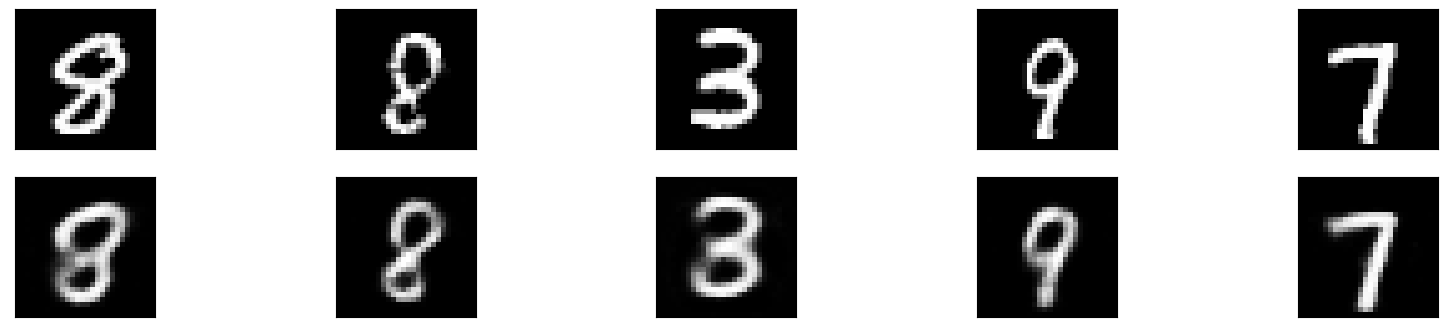

In [33]:
images, labels = next(iter(valloader))

img = images[0].view(1, 784)
with torch.no_grad():
    logps = model.encoder(images.view(-1, 784))
    decoded = model.decoder(logps)

plt.figure(figsize=(20, 4))
for i in range(5):
    # Display original
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(images[i].reshape(28, 28))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, 5, i + 1 + 5)
    plt.imshow(decoded[i].reshape(28, 28))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [68]:
noise_factor = 0.7
x_train_noisy = images + noise_factor * torch.randn(*images.shape)
x_train_noisy = np.clip(x_train_noisy, -1., 1.)
print(images[0][0][14])
print(x_train_noisy[0][0][14])

tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.9451,
        -0.4902,  0.4824,  0.9843,  0.9765,  0.9765,  0.9765,  0.8196,  0.8118,
         0.8039,  0.9294,  0.9765,  0.1529, -0.9137, -1.0000, -1.0000, -1.0000,
        -1.0000, -1.0000, -1.0000, -1.0000])
tensor([ 0.0496, -0.2542, -0.5161, -1.0000, -0.5685, -1.0000, -0.5567, -1.0000,
        -0.1925, -0.1503,  1.0000,  1.0000, -0.1070,  1.0000,  0.8041, -0.7080,
         0.9931, -0.3137, -1.0000,  1.0000, -1.0000, -0.0554, -1.0000, -1.0000,
        -1.0000, -0.1472, -1.0000,  1.0000])


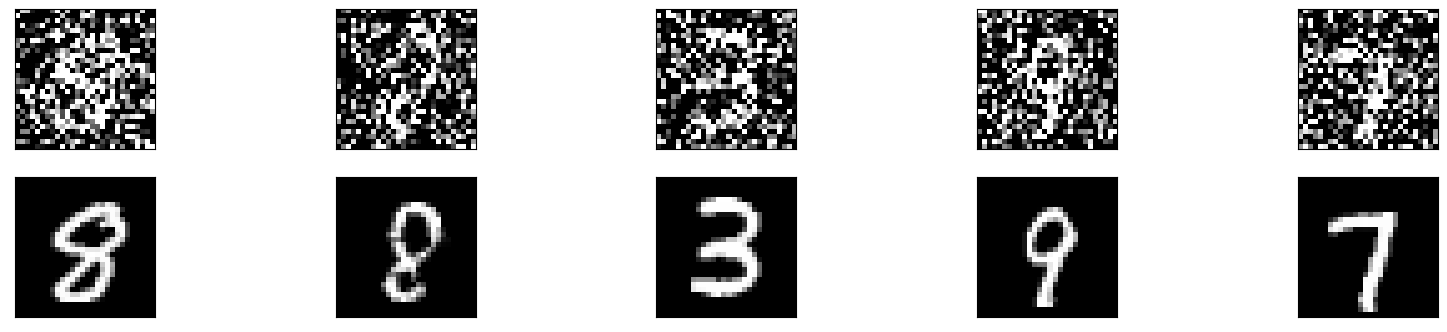

In [69]:
plt.figure(figsize=(20, 4))
for i in range(5):
    # Display original
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(x_train_noisy[i].reshape(28, 28))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(2, 5, i + 1 + 5)
    plt.imshow(images[i].reshape(28, 28))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [73]:
optimizer = optim.Adam(model.parameters(), lr=0.003, weight_decay=1e-5)
time0 = time()
epochs = 10
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        x_train_noisy = images + noise_factor * torch.randn(*images.shape)
        x_train_noisy = np.clip(x_train_noisy, -1., 1.)
        # Training pass
        
        output = model(x_train_noisy)
        loss = criterion(output, images)
        
        #This is where the model learns by backpropagating
        optimizer.zero_grad()
        loss.backward()
        
        #And optimizes its weights here
        optimizer.step()
        
        running_loss += loss.item()
    else:
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))
print("\nTraining Time (in minutes) =",(time()-time0)/60)

Epoch 0 - Training loss: 0.12623217991038935
Epoch 1 - Training loss: 0.12553666451020534
Epoch 2 - Training loss: 0.12545558079473498
Epoch 3 - Training loss: 0.12510777661985933
Epoch 4 - Training loss: 0.12496001442580588
Epoch 5 - Training loss: 0.12501830621950152
Epoch 6 - Training loss: 0.12488075505409922
Epoch 7 - Training loss: 0.12456211979900088
Epoch 8 - Training loss: 0.12437552818929208
Epoch 9 - Training loss: 0.12446720955341356

Training Time (in minutes) = 3.9952678442001344


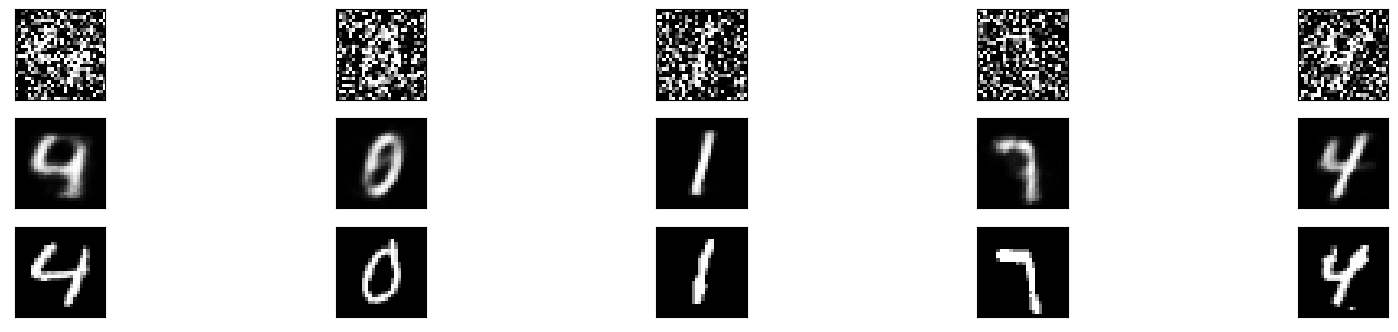

In [79]:
images, labels = next(iter(valloader))

x_train_noisy = images + noise_factor * torch.randn(*images.shape)
x_train_noisy = np.clip(x_train_noisy, -1., 1.)
with torch.no_grad():
    denoised_images = model(x_train_noisy.view(-1, 784))

plt.figure(figsize=(20, 4))
for i in range(5):
    # Display original
    ax = plt.subplot(3, 5, i + 1)
    plt.imshow(x_train_noisy[i].reshape(28, 28))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Display reconstruction
    ax = plt.subplot(3, 5, i + 1 + 5)
    plt.imshow(denoised_images[i].reshape(28, 28))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # Display reconstruction
    ax = plt.subplot(3, 5, i + 1 + 10)
    plt.imshow(images[i].reshape(28, 28))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()